# Projekt - Algorytmy geometryczne

#### Autor: Mateusz Kocot
Problem: Mając daną chmurę punktów na płaszczyźnie dwuwymiarowej, wyznaczyć:
 - minimalny okrąg zawierający tę chmurę,
 - prostokąt o minimalnym polu powierzchni zawierający tę chumrę,
 - prostokąt o minimalnym obwodzie zawierający tę chmurę.

### Konfiguracja aplikacji graficznej
źródło: https://github.com/Podsiadlo

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [99]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        return [b_prev, b_next, b_add_point]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

### Wprowadzanie punktów, funkcje generujące zbiory punktów

<IPython.core.display.Javascript object>


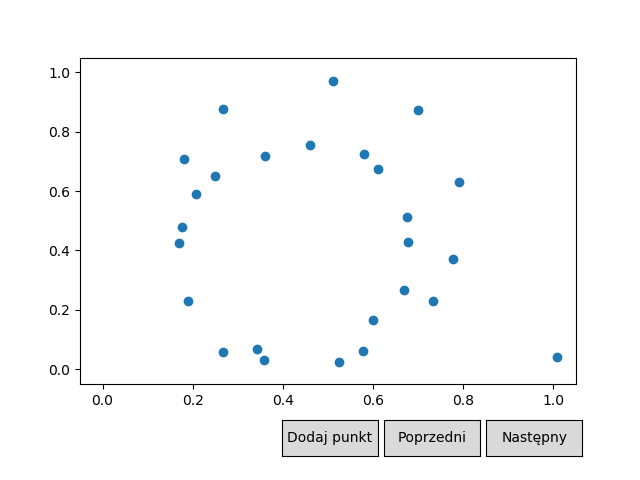

In [86]:
# Interaktywne wprowadzanie punktów
%matplotlib notebook
plot1 = Plot()
plot1.draw()

In [100]:
# Zapisanie wprowadzonych punktów
sets = []
desc = []

plot2 = Plot([plot1.get_added_elements()])    
data = js.loads(plot2.toJson())
if data[0]["points"]:
    sets.append([P for P in data[0]["points"][0]])
    desc.append("Interaktywnie")

# Funkcje generujące zbiory punktów
import random
import math

num = 40  # Liczba generowanych punktów

def gen_set1 (n = 100, xmin = -100, xmax = 100, ymin = -100, ymax = 100):  # Punkty generowane losowo w podanym zakresie
    set1 = []
    for i in range(n):
        set1.append(((random.uniform(xmin, xmax)), (random.uniform(ymin, ymax))))
    return set1

sets.append(gen_set1(num))
desc.append("Losowo")

def gen_set2 (n = 100, R = 10, ox = 0, oy = 0):  # Punkty generowano losowo na zadanym okręgu
    set2 = []
    for i in range(n):
        alpha = 2 * math.pi * random.random()
        x = R * math.cos(alpha) + ox
        y = R * math.sin(alpha) + oy
        set2.append((x, y))
    return set2

sets.append(gen_set2(num))
desc.append("Na okręgu")

def gen_set3 (n = 100, P = [(-10, 10), (-10, -10), (10, -10), (10, 10)]):  # Punkty generowane losowo na 
    set3 = []                                                              # bokach zadanego prostokąta
    if (P[0][0] - P[1][0] == 0 or P[0][1] - P[1][1] == 0): #boki równoległe do osi ukł. wsp.
        T = [[P[0][0], P[0][1]], [P[0][0], P[0][1]]]
        for i in range(4):
            if (P[i][0] < T[0][0]):
                T[0][0] = P[i][0]
            if (P[i][1] < T[0][1]):
                T[0][1] = P[i][1]
            if (P[i][0] > T[1][0]):
                T[1][0] = P[i][0]
            if (P[i][0] > T[1][0]):
                T[1][0] = P[i][0]
        P = [(T[0][0], T[0][1]), (T[1][0], T[0][1]), (T[1][0], T[1][1]), (T[0][0], T[1][1])]
        for i in range(n):
            l = random.randint(0, 3)
            if (l % 2 == 0):
                x = P[l][0] + random.random() * (P[l+1][0] - P[l][0])
                y = P[l][1]
            else:
                x = P[l][0]
                y = P[l][1] + random.random() * (P[(l+1) % 4][1] - P[l][1])
            set3.append((x, y))
    else: #dowolny prostokąt o bokach nierównoległych do osi ukł. wsp.
        a = []
        b = []
        for i in range(4):
            a.append((P[i][1] - P[(i+1) % 4][1]) / (P[i][0] - P[(i+1) % 4][0]))
            b.append(P[i][1] - P[i][0] * a[i])
        
        for i in range(n):
            l = random.randint(0, 3)
            x = P[l][0] + random.random() * (P[(l+1) % 4][0] - P[l][0])
            y = a[l] * x + b[l]
            set3.append((x, y))
    return set3

sets.append(gen_set3(num))
desc.append("Na prostokącie")

sets.append(gen_set3(num, [(0, 0), (1, -2), (4, 0), (3, 2)]))
desc.append("Na krzywym prostokącie")

<IPython.core.display.Javascript object>


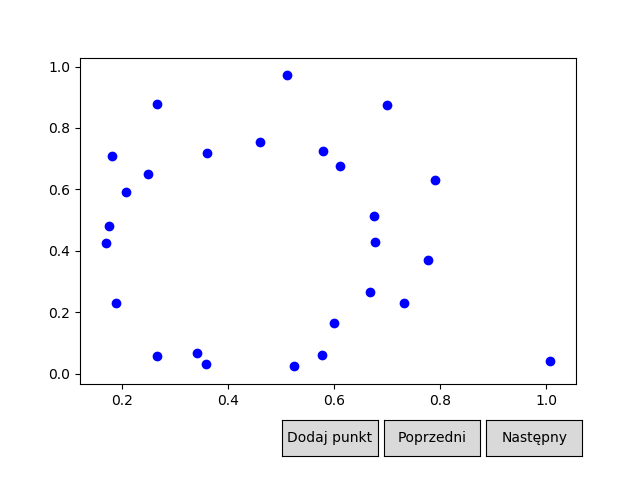

In [101]:
# Wizualizacja utworzonych zbiorów

scenes = [Scene([PointsCollection(set, color = 'blue')]) for set in sets]

plot = Plot(scenes)
plot.draw() 

### Funkcje pomocnicze

In [102]:
CIRCLE_PREC = 100   # Okrąg na wizualizacji będzie składał się z tylu odcinków

def circle_segments(D):   # Funkcja zwracająca okrąg (właściwie - listę odcinków)
    S = D[0]
    r = D[1]
    theta = np.linspace(0, 2*np.pi, 100)
    x = S[0] + r*np.cos(theta)
    y = S[1] + r*np.sin(theta)
    lines = [[[x[i], y[i]], [x[(i + 1) % CIRCLE_PREC], y[(i + 1) % CIRCLE_PREC]]] for i in range(CIRCLE_PREC)]
    return lines

def dist(A, B):
    return math.sqrt((A[0] - B[0]) ** 2 + (A[1] - B[1]) ** 2)

## Minimalny okrąg

### Algorytm Welzla

<IPython.core.display.Javascript object>


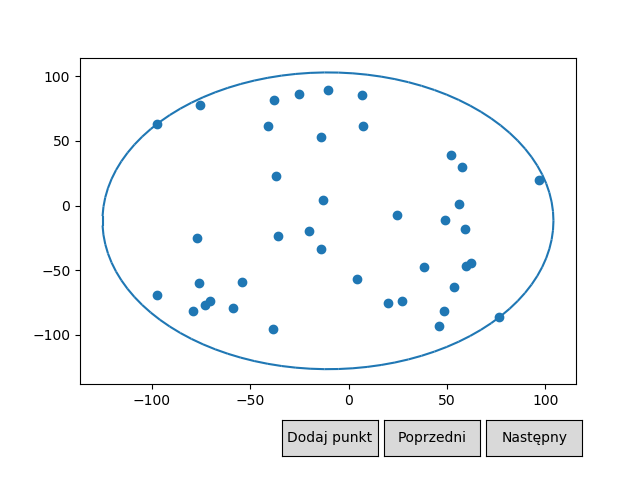

In [103]:
# dla |R| <= 3 funkcja zwraca środek i promień takiego koła, które zawiera zadane punkty i jest możliwie najmniejsze.
def trivial(R): 
    if not R:          # Dla 0 punktów - None
        return None
    elif len(R) == 1:  # Dla 1 punktu - okrąg o promieniu 0
        return (R[0], 0)
    elif len(R) == 2:  # Dla 2 punktów - okrąg o środku w połowie odcinka i promieniu równym 
        S = ((R[0][0] + R[1][0]) / 2, (R[0][1] + R[1][1]) / 2)
        r = dist(S, R[1])
        return (S, r)
    else:              # Dla 3 punktów:
        A = R[0]
        B = R[1]
        C = R[2]
        
        a = [(dist(A, B), A, B), (dist(B, C), B, C), (dist(C, A), C, A)]
        a.sort(key = lambda k : k[0])
        
        if a[0][0] ** 2 + a[1][0] ** 2 < a[2][0] ** 2:  # Trójkąt rozwartokątny - brane pod uwagę są tylko dwa
            S = ((a[2][1][0] + a[2][2][0]) / 2, (a[2][1][1] + a[2][2][1]) / 2)  # punkty najdłuższego boku
            r = dist(S, a[2][1])
            return (S, r)
        
        if B[1] - A[1] != 0: # W przeciwnym wypadku - okrąg opisany na danych trzech punktach
            a1 = - ((B[0] - A[0]) / (B[1] - A[1]))
            b1 = (A[1] + B[1]) / 2 - a1 * (A[0] + B[0]) / 2
        else:
            a1 = - ((B[0] - C[0]) / (B[1] - C[1]))
            b1 = (C[1] + B[1]) / 2 - a1 * (C[0] + B[0]) / 2
        
        if C[1] - A[1] != 0:
            a2 = - ((C[0] - A[0]) / (C[1] - A[1]))
            b2 = (A[1] + C[1]) / 2 - a2 * (A[0] + C[0]) / 2
        else:
            a2 = - ((C[0] - B[0]) / (C[1] - B[1]))
            b2 = (B[1] + C[1]) / 2 - a2 * (B[0] + C[0]) / 2
        
        if a1 - a2 != 0:
            xs = (b2 - b1) / (a1 - a2)
        else:
            xs = 0
        ys = a1 * xs + b1
        S = (xs, ys)
        r = dist(S, A)
        return (S, r)
    
def choose_random(P):  # Losowy wybór punktu (zwraca indeks)
    p = P[random.randint(0, len(P) - 1)]
    return p
        
def includes(D, p): # Zwraca True, gdy punkt p leży we wnętrzu koła D
    if D == None:
        return False
    S = D[0]
    r = D[1]
    if (p[0] - S[0]) ** 2 + (p[1] - S[1]) ** 2 <= r ** 2:
        return True
    else:
        return False
    
def smallest_circle(P):
    return __smallest_circle(P, [])

def __smallest_circle(P, R): # Właściwy algorytm Welzla
    if not P or len(R) == 3:
        return trivial(R)
    p = choose_random(P)
    P2 = [k for k in P if k != p]
    D = __smallest_circle(P2, R)
    if includes(D, p):
        return D
    else:
        return __smallest_circle(P2, R + [p])
    
# Wizualizacja wyniku:
scenes = [Scene([PointsCollection(set)],
                [LinesCollection(circle_segments(smallest_circle(set)))]) for set in sets]

plot = Plot(scenes)
plot.draw() 